In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

%load_ext autoreload
%autoreload

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np

import torch

from hydra import initialize, compose
from hydra.utils import instantiate

from ptls.preprocessing import PandasDataPreprocessor
from ptls.frames import PtlsDataModule

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from src.coles import CustomColesDataset, CustomCoLES, CustomUserValidationColesDataset
from src.local_validation import LocalValidationModel

from ptls.frames.coles.split_strategy import NoSplit
from ptls.frames.coles import ColesDataset

from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter

In [3]:
from src.users_validation import UsersValidationModel

In [4]:
pd.__version__

'1.4.0'

# Example with raif dataset


In [5]:
with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config_raif")
    
cfg_preprop = cfg["dataset"]
cfg_model = cfg["model"]
cfg_validation = cfg["validation"]

In [6]:
# residenttype: R => 1
#               N => 0

# gender: F => 0
#         M => 1

# married: not_married => 0
#          married => 1

# age: without changes

df = pd.read_parquet(Path(cfg["dataset"]["dir_path"]).joinpath(cfg["dataset"]["train_file_name"]))
df

,timestamp,amount,mcc_code,user_id,categorycode,gender,age,residenttype,married
0,2019-11-02,9000000.00,215,1183902,17,0,59,1,1
1,2019-11-02,9000000.00,215,1183902,17,0,59,1,1
2,2019-11-02,5000000.00,215,1183902,17,0,59,1,1
3,2019-11-02,5000000.00,215,1183902,17,0,59,1,1
4,2019-11-07,1148610.31,139,1183902,17,0,59,1,1
...,...,...,...,...,...,...,...,...,...
104161403,2019-10-23,0.08,155,563333,70,1,31,1,1
104161404,2019-11-23,0.04,155,563333,70,1,31,1,1
104161405,2019-10-05,0.05,283,997465,70,0,41,1,0
104161406,2019-10-14,0.03,283,924652,70,0,44,1,1


In [7]:
np.random.seed(42)
users = np.random.choice(df["user_id"].unique(), size=10_000)
df.index = df.user_id
df = df.loc[users]

In [8]:
preprocessor = PandasDataPreprocessor(
    col_id="user_id",
    col_event_time="timestamp",
    event_time_transformation="dt_to_timestamp",
    cols_category=["mcc_code", "categorycode"],
    category_transformation="frequency",
    cols_numerical=["amount"],  # keep column with fake local targets
    cols_first_item=["married", "gender", "categorycode", "residenttype", "age"],
    return_records=True,
)

dataset = preprocessor.fit_transform(df)

valid_size = cfg_preprop["coles"]["valid_size"]
test_size = cfg_preprop["coles"]["test_size"]

train, val_test = train_test_split(
    dataset,
    test_size=valid_size+test_size,
    random_state=cfg_preprop["coles"]["random_state"]
)

val, test = train_test_split(
    val_test,
    test_size=test_size/(valid_size+test_size),
    random_state=cfg_preprop["coles"]["random_state"]
)

In [9]:
# # initialize original CoLES datasest - for CoLES training
# train_data: CustomColesDataset = instantiate(cfg_model["dataset"], data=train)
# val_data: CustomColesDataset = instantiate(cfg_model["dataset"], data=val)
    
# train_datamodule: PtlsDataModule = instantiate(
#     cfg_model["datamodule"],
#     train_data=train_data,
#     valid_data=val_data
# )

In [10]:
model: CustomCoLES = instantiate(cfg_model["model"])

In [11]:
# model_checkpoint: ModelCheckpoint = instantiate(
#     cfg_model["trainer_coles"]["checkpoint_callback"],
#     monitor=model.metric_name,
#     mode="max"
# )
    
# early_stopping: EarlyStopping = instantiate(
#     cfg_model["trainer_coles"]["early_stopping"],
#     monitor=model.metric_name,
#     mode="max"
# )
    
# logger: TensorBoardLogger = instantiate(cfg_model["trainer_coles"]["logger"])
    
# trainer: Trainer = instantiate(
#     cfg_model["trainer_coles"]["trainer"],
#     callbacks=[model_checkpoint, early_stopping],
#     logger=logger
# )
    
# trainer.fit(model, train_datamodule)

In [12]:
# torch.save(model.state_dict(), "saved_models/coles_raif_default.pth")

In [13]:
model.load_state_dict(torch.load("saved_models/coles_raif_default.pth"))

<All keys matched successfully>

In [14]:
min_len = 20
col_time = "event_time"

data_train = MemoryMapDataset(train, [SeqLenFilter(min_len)])
data_val = MemoryMapDataset(val, [SeqLenFilter(min_len)])

train_data_no_split = ColesDataset(
    data_train,
    NoSplit(),
    col_time
)

val_data_no_split = ColesDataset(
    data_val,
    NoSplit(),
    col_time
)

In [15]:
train_data_no_split = CustomUserValidationColesDataset(data_train,
                                              NoSplit(),
                                              col_time,
                                              target_cols = ['gender', 'age', 'residenttype', 'married'])
val_data_no_split = CustomUserValidationColesDataset(data_val,
                                              NoSplit(),
                                              col_time,
                                              target_cols = ['gender', 'age', 'residenttype', 'married'])

datamodule = PtlsDataModule(
    train_data=train_data_no_split,
    valid_data=val_data_no_split,
    test_data=val_data_no_split,
    train_batch_size=4,
    valid_batch_size=4, 
    test_batch_size=4
)

In [16]:
x, y = next(iter(datamodule.train_dataloader()))
backbone = model.seq_encoder

x.payload.keys(), x.payload["event_time"].shape,  y, backbone(x).shape

(dict_keys(['event_time', 'mcc_code', 'amount']),
 torch.Size([4, 266]),
 {'gender': tensor([1., 1., 1., 0.]),
  'age': tensor([34., 26., 33., 46.]),
  'residenttype': tensor([0., 1., 1., 1.]),
  'married': tensor([0., 0., 0., 0.])},
 torch.Size([4, 1024]))

In [17]:
val_model = UsersValidationModel(backbone = backbone,
                             backbone_embd_size = 1024,
                             hidden_size = 1024)


In [18]:
val_model(x)

{'gender': tensor([[0.4988],
         [0.5025],
         [0.5012],
         [0.5054]], grad_fn=<SigmoidBackward0>),
 'age': tensor([[0.0217],
         [0.0326],
         [0.0302],
         [0.0128]], grad_fn=<AddmmBackward0>),
 'residenttype': tensor([[0.4810],
         [0.4883],
         [0.4948],
         [0.4731]], grad_fn=<SigmoidBackward0>),
 'married': tensor([[0.4931],
         [0.5014],
         [0.5071],
         [0.4975]], grad_fn=<SigmoidBackward0>)}

In [19]:
val_trainer: Trainer = instantiate(cfg_validation["trainer"])
    
val_trainer.fit(val_model, datamodule)
val_trainer.test(val_model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params
---------------------------------------------
0 | backbone   | RnnSeqEncoder | 4.3 M 
1 | pred_heads | ModuleDict    | 4.2 M 
---------------------------------------------
4.2 M     Trainable params
4.3 M     Non-trainable params
8.5 M     Total params
34.072    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      AUROC_gender          0.8319128751754761
      AUROC_married         0.6398079991340637
   AUROC_residenttype       0.7141621112823486
     Accuracy_gender        0.7331081032752991
    Accuracy_married        0.6402027010917664
  Accuracy_residenttype     0.9763513803482056
     F1Score_gender         0.7755681872367859
     F1Score_married        0.3486238420009613
  F1Score_residenttype       0.988034188747406
         MAE_age             7.199037075042725
         MSE_age             82.4435806274414
      PR-AUC_gender          0.864482045173645
     PR-AUC_married         0.5285336375236511
   PR-AUC_residenttype      0.9905225038528442
─────────────────────────────────────────────────────────

[{'AUROC_gender': 0.8319128751754761,
  'PR-AUC_gender': 0.864482045173645,
  'Accuracy_gender': 0.7331081032752991,
  'F1Score_gender': 0.7755681872367859,
  'MAE_age': 7.199037075042725,
  'MSE_age': 82.4435806274414,
  'AUROC_residenttype': 0.7141621112823486,
  'PR-AUC_residenttype': 0.9905225038528442,
  'Accuracy_residenttype': 0.9763513803482056,
  'F1Score_residenttype': 0.988034188747406,
  'AUROC_married': 0.6398079991340637,
  'PR-AUC_married': 0.5285336375236511,
  'Accuracy_married': 0.6402027010917664,
  'F1Score_married': 0.3486238420009613}]

# Clustering

In [20]:
clustering_columns = ["gender", "married", "residenttype", "age"]

In [21]:
data = df[clustering_columns + ["user_id"]].drop_duplicates()[clustering_columns]
ids = df[clustering_columns + ["user_id"]].drop_duplicates().index

In [22]:
data["age"].quantile(0.10), data["age"].quantile(0.5), data["age"].quantile(0.90), 

(27.0, 39.0, 57.0)

(array([ 315., 1377., 2587., 2103., 1628., 1049.,  670.,  186.,   37.,
          13.]),
 array([15. , 22.1, 29.2, 36.3, 43.4, 50.5, 57.6, 64.7, 71.8, 78.9, 86. ]),
 <BarContainer object of 10 artists>)

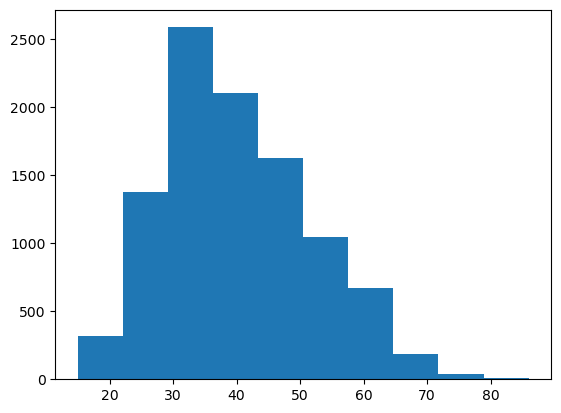

In [23]:
import matplotlib.pyplot as plt
plt.hist(data["age"])

In [24]:
np.unique(data["residenttype"].values, return_counts = True)

(array([0, 1], dtype=int64), array([ 303, 9662], dtype=int64))

In [25]:
import numpy as np
from sklearn.cluster import KMeans

from tqdm import tqdm


In [26]:
import torch.nn as nn
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering


class UsersClusteringValidation():

    def __init__(
        self,
        backbone: nn.Module,
        clustering_algorithm = KMeans(),
        backbone_output_type: str = "tensor",
        binary_columns = ["gender", "married", "residenttype"], 
        cont_columns = ["age"], 
        cont_columns_threasholds = [[39]]
    ) -> None:

        super().__init__()

        assert backbone_output_type in [
            "tensor",
            "padded_batch",
        ], f"Unknown output type of the backbone model {backbone_output_type}"

        self.backbone = backbone
        # freeze backbone model
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.binary_columns = binary_columns
        self.cont_columns = cont_columns
        self.cont_columns_threasholds = cont_columns_threasholds
        self.algo = clustering_algorithm

    def cluster_assignation(self, data):
        dt = data.copy()
        dt["cluster"] = 0
        for  i, binary_column in enumerate(self.binary_columns):
            dt["cluster"] += dt[binary_column] * 2**i
        num_clusters = 2**len(self.binary_columns) 

        for cont_column, cont_column_threashold in zip(self.cont_columns, self.cont_columns_threasholds):
            dt["cluster_" + cont_column] = 0
            for i in range(len(cont_column_threashold)):
                value = cont_column_threashold[i]
                if i != len(cont_column_threashold) - 1:
                    next_value = cont_column_threashold[i+1]
                    dt.loc[(dt[cont_column] >= value) & (dt[cont_column] < next_value), "cluster_" + cont_column] = i+1
                else:
                    dt.loc[dt[cont_column] >= value, "cluster_" + cont_column] = i+1

            dt["cluster"] += (dt["cluster_" + cont_column]) * num_clusters
            num_clusters *= (len(cont_column_threashold) + 1)
            dt = dt.drop("cluster_" + cont_column, axis = 1)

        return dt, num_clusters
    
    def get_data(self, dataloader):

        embeddings = torch.tensor([])
        targets = {}
        for column in (self.binary_columns + self.cont_columns):
            targets[column] = torch.tensor([])

        for batch in tqdm(dataloader):
            x, y = batch
            for key, value in y.items():
                try:
                    targets[key] = torch.cat((targets[key], value))
                except Exception as ex:
                    pass 
            emb = self.backbone(x)
            embeddings = torch.cat((embeddings, emb))

        targets, num_clusters = self.cluster_assignation(pd.DataFrame(targets))
        targets = targets["cluster"].values.astype("int")
        embeddings = embeddings.detach().cpu().numpy()

        return embeddings, targets, num_clusters

    def train(self, datamodule):
        
        embeddings, targets, num_clusters = self.get_data(datamodule.train_dataloader())
        
        try: 
            self.algo.n_clusters = num_clusters
        except Exception as ex:
            pass

        self.algo.fit(embeddings)

        preds = self.algo.predict(embeddings)
        return targets, preds
    
    def test(self, datamodule):
        embeddings, targets, _ = self.get_data(datamodule.test_dataloader()) 
        preds = self.algo.predict(embeddings)
        
        result = {
            'ARI': metrics.adjusted_rand_score(targets, preds),
            'AMI': metrics.adjusted_mutual_info_score(targets, preds),
            'Homogenity': metrics.homogeneity_score(targets, preds),
            'Completeness': metrics.completeness_score(targets, preds),
            'V-measure': metrics.v_measure_score(targets, preds),
            # 'Silhouette': metrics.silhouette_score(targets, preds)
                }
        return targets, preds, result

In [29]:
np.random.seed(42)
clustering = UsersClusteringValidation(backbone,
        clustering_algorithm = KMeans(random_state=42),
        )

In [30]:
targets, preds = clustering.train(datamodule)
targets, preds, result = clustering.test(datamodule)
result

100%|██████████| 148/148 [00:12<00:00, 12.18it/s]


{'ARI': 0.017551810533112503,
 'AMI': 0.03324974061367844,
 'Homogenity': 0.09956875466833816,
 'Completeness': 0.0787509995641524,
 'V-measure': 0.08794470348210931}

In [31]:
targets, preds = clustering.train(datamodule)
targets, preds, result = clustering.test(datamodule)
result

100%|██████████| 148/148 [00:16<00:00,  8.93it/s]


{'ARI': 0.015850517129371577,
 'AMI': 0.03542093755071669,
 'Homogenity': 0.10201091858049421,
 'Completeness': 0.08032231948138738,
 'V-measure': 0.08987668600533925}

In [32]:
np.unique(targets), np.unique(preds) 

(array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))